#1 新闻组文本数据不同分类器间的比较

开始下载/加载数据...


下载/加载数据完成，耗时2.018秒
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']




分类器的比较：

分类器： MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


5折交叉验证的训练时间为：1.458秒/(5*10)=0.029秒
最优超参数为： {'alpha': 0.0035938136638046258}
测试时间：0.003秒
测试集准确率：89.58%


分类器： BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


5折交叉验证的训练时间为：2.258秒/(5*10)=0.045秒
最优超参数为： {'alpha': 0.001}
测试时间：0.025秒
测试集准确率：88.54%


分类器： KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


5折交叉验证的训练时间为：31.062秒/(5*14)=0.444秒
最优超参数为： {'n_neighbors': 3}


测试时间：0.343秒
测试集准确率：86.03%


分类器： RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)


5折交叉验证的训练时间为：50.740秒/(5*10)=1.015秒
最优超参数为： {'alpha': 0.01291549665014884}
测试时间：0.003秒
测试集准确率：89.36%


分类器： RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


5折交叉验证的训练时间为：72.067秒/(5*6)=2.402秒
最优超参数为： {'max_depth': 9}


测试时间：0.352秒
测试集准确率：77.01%


分类器： SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


5折交叉验证的训练时间为：452.954秒/(5*9)=10.066秒
最优超参数为： {'gamma': 0.031622776601683791, 'C': 100.0}


测试时间：2.759秒
测试集准确率：90.10%




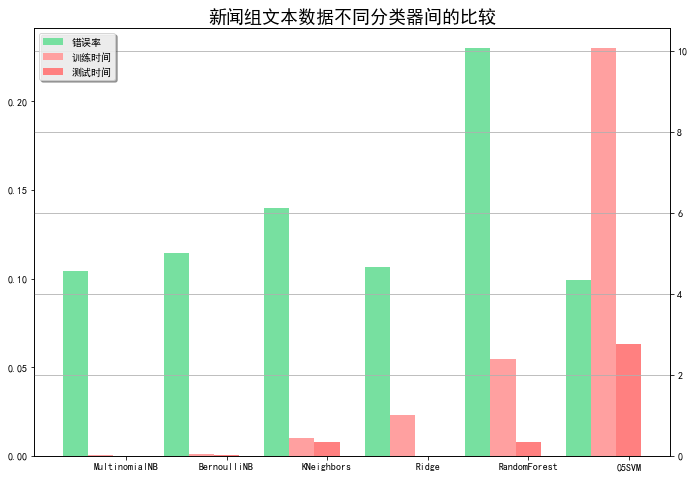

In [3]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from time import time
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl


def test_clf(clf):
    print(u'分类器：', clf)
    alpha_can = np.logspace(-3, 2, 10)
    model = GridSearchCV(clf, param_grid={'alpha': alpha_can}, cv=5)
    m = alpha_can.size
    if hasattr(clf, 'alpha'):
        model.set_params(param_grid={'alpha': alpha_can})
        m = alpha_can.size
    if hasattr(clf, 'n_neighbors'):
        neighbors_can = np.arange(1, 15)
        model.set_params(param_grid={'n_neighbors': neighbors_can})
        m = neighbors_can.size
    if hasattr(clf, 'C'):
        C_can = np.logspace(1, 3, 3)
        gamma_can = np.logspace(-3, 0, 3)
        model.set_params(param_grid={'C':C_can, 'gamma':gamma_can})
        m = C_can.size * gamma_can.size
    if hasattr(clf, 'max_depth'):
        max_depth_can = np.arange(4, 10)
        model.set_params(param_grid={'max_depth': max_depth_can})
        m = max_depth_can.size
    t_start = time()
    model.fit(x_train, y_train)
    t_end = time()
    t_train = (t_end - t_start) / (5*m)
    print(u'5折交叉验证的训练时间为：%.3f秒/(5*%d)=%.3f秒' % ((t_end - t_start), m, t_train))
    print(u'最优超参数为：', model.best_params_)
    t_start = time()
    y_hat = model.predict(x_test)
    t_end = time()
    t_test = t_end - t_start
    print(u'测试时间：%.3f秒' % t_test)
    acc = metrics.accuracy_score(y_test, y_hat)
    print(u'测试集准确率：%.2f%%' % (100 * acc))
    name = str(clf).split('(')[0]
    index = name.find('Classifier')
    if index != -1:
        name = name[:index]     # 去掉末尾的Classifier
    if name == 'SVC':
        name = '05SVM'
    return t_train, t_test, 1-acc, name

print(u'开始下载/加载数据...')
t_start = time()
# remove = ('headers', 'footers', 'quotes')
remove = ()
categories = 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'
# categories = None     # 若分类所有类别，请注意内存是否够用
data_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=0, remove=remove)
data_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=0, remove=remove)
t_end = time()
print(u'下载/加载数据完成，耗时%.3f秒' % (t_end - t_start))
categories = data_train.target_names
pprint(categories)
y_train = data_train.target
y_test = data_test.target

vectorizer = TfidfVectorizer(input='content', stop_words='english', max_df=0.5, sublinear_tf=True)
x_train = vectorizer.fit_transform(data_train.data)  # x_train是稀疏的，scipy.sparse.csr.csr_matrix
x_test = vectorizer.transform(data_test.data)
# print(u'训练集样本个数：%d，特征个数：%d' % x_train.shape)

feature_names = np.asarray(vectorizer.get_feature_names())

print(u'\n\n===================\n分类器的比较：\n')
clfs = (MultinomialNB(),                # 0.87(0.017), 0.002, 90.39%
        BernoulliNB(),                  # 1.592(0.032), 0.010, 88.54%
        KNeighborsClassifier(),         # 19.737(0.282), 0.208, 86.03%
        RidgeClassifier(),              # 25.6(0.512), 0.003, 89.73%
        RandomForestClassifier(n_estimators=200),   # 59.319(1.977), 0.248, 77.01%
        SVC()                           # 236.59(5.258), 1.574, 90.10%
        )
result = []
for clf in clfs:
    a = test_clf(clf)
    result.append(a)
    print('\n')
result = np.array(result)
time_train, time_test, err, names = result.T
time_train = time_train.astype(np.float)
time_test = time_test.astype(np.float)
err = err.astype(np.float)
x = np.arange(len(time_train))
mpl.rcParams['font.sans-serif'] = [u'simHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 7), facecolor='w')
ax = plt.axes()
b1 = ax.bar(x, err, width=0.25, color='#77E0A0')
ax_t = ax.twinx()
b2 = ax_t.bar(x+0.25, time_train, width=0.25, color='#FFA0A0')
b3 = ax_t.bar(x+0.5, time_test, width=0.25, color='#FF8080')
plt.xticks(x+0.5, names)
plt.legend([b1[0], b2[0], b3[0]], (u'错误率', u'训练时间', u'测试时间'), loc='upper left', shadow=True)
plt.title(u'新闻组文本数据不同分类器间的比较', fontsize=18)
plt.xlabel(u'分类器名称')
plt.grid(True)
plt.tight_layout(2)
plt.show()